In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import utils

In [5]:
from utils import KernelFunction, KernelEnvironment
from utils import plot_kernel_function, compare_kernels

## Testing Kernel Functions


In [3]:
k = KernelFunction()
print(k)
k1 = k.rbf(lengthscale=1.0)
print(k1)
k2 = k.linear(variances=0.5)
k3 = k1.add(k2).multiply(k.linear(variances=2.0))

print(k3)
# Output: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))

Identity({})
RBF({'lengthscale': 1.0, 'variance': 1.0})
((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))


In [61]:
# Step 1: Generate synthetic data
np.random.seed(42)

# Inputs: 50 points in [0, 10]
X = np.linspace(0, 10, 50)[:, None]

# Ground-truth function: nonlinear + linear trend
Y_true = np.sin(X) + 0.5 * X
Y = Y_true + 0.3 * np.random.randn(*X.shape)  # add noise

# Step 2: Define composite kernel k3 = (RBF + Linear) * Linear
input_dim = X.shape[1]

# Step 3: Create and optimize GP model
real_k3 = k3.evaluate(input_dim=X.shape[1])
model = GPy.models.GPRegression(X, Y, kernel=real_k3)
model.optimize(messages=True)

# Print model info
print(model)

# Step 4: Predict and plot
Xtest = np.linspace(0, 10, 200)[:, None]
mean, var = model.predict(Xtest)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   7.507626e+01   2.582879e+02 
    00s05  0005   2.532184e+01   1.235584e+01 
    00s12  0015   2.252140e+01   4.305033e-02 
    00s18  0023   2.250410e+01   3.438539e-04 
    00s19  0024   2.250392e+01   8.577531e-05 
    00s29  0054   2.250370e+01   1.814082e-07 
Runtime:     00s29
Optimization status: Converged


Name : GP regression
Objective : 22.50370157650146
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.            |                  value  |  constraints  |  priors
  mul.sum.rbf.variance      |     10.057389982767729  |      +ve      |        
  mul.sum.rbf.lengthscale   |     3.5177481434056066  |      +ve      |        
  mul.sum.linear.variances  |  4.534464658764253e-08  |      +ve      |        
  mul.linear.variances      |    0.14238011833170008  |      +ve      |        
  Gaussian_noise.variance   |    

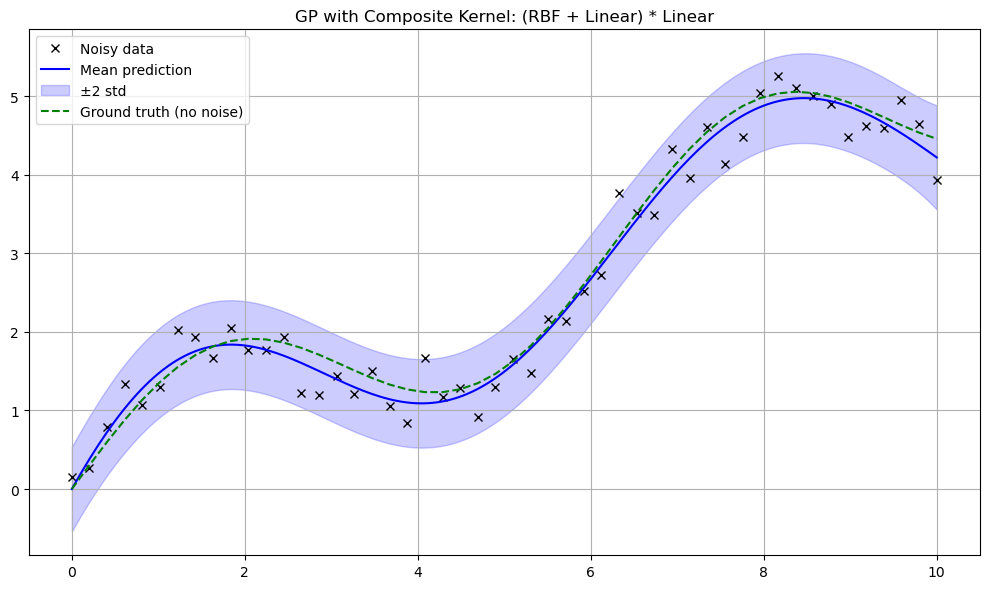

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(X, Y, "kx", label="Noisy data")
plt.plot(Xtest, mean, "b", label="Mean prediction")
plt.fill_between(Xtest.flatten(),
                 mean.flatten() - 2 * np.sqrt(var.flatten()),
                 mean.flatten() + 2 * np.sqrt(var.flatten()),
                 color="blue", alpha=0.2, label="±2 std")
plt.plot(X, Y_true, "g--", label="Ground truth (no noise)")
plt.title("GP with Composite Kernel: (RBF + Linear) * Linear")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Testing Kernel Env

In [63]:
import torch
# A dummy log_reward function for instantiation
def lr():
    pass

BATCH_SIZE = 2
MAX_LEN = 3

env = KernelEnvironment(batch_size=BATCH_SIZE, max_trajectory_length=MAX_LEN, log_reward=lr)

print("--- Initial State ---")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"Initial 'is_initial' flags: {env.is_initial}")
print(f"Initial 'stopped' flags: {env.stopped}")
print(f"Action mask for batch 0 (cannot end): {env.mask[0]}")
print("-" * 25)



--- Initial State ---
Batch 0: Identity({})
Batch 1: Identity({})
Initial 'is_initial' flags: tensor([1., 1.])
Initial 'stopped' flags: tensor([0., 0.])
Action mask for batch 0 (cannot end): tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])
-------------------------


In [64]:
# --- Step 1 ---
# Action 0: add RBF, Action 5: multiply Linear
actions_t1 = torch.tensor([0, 5]) 
env.apply(actions_t1)
print("--- After Step 1 (Apply [add RBF, mul Linear]) ---")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"'is_initial' flags: {env.is_initial}")
print(f"Action mask for batch 0 (can end): {env.mask[0]}")
print("-" * 25)



--- After Step 1 (Apply [add RBF, mul Linear]) ---
Batch 0: (Identity({}) + RBF({'lengthscale': 1.0, 'variance': 1.0}))
Batch 1: (Identity({}) * Linear({'variances': 1.0}))
'is_initial' flags: tensor([False, False])
Action mask for batch 0 (can end): tensor([True, True, True, True, True, True, True, True, True])
-------------------------


In [65]:
# --- Step 2 ---
# Action 6: multiply Periodic, Action 8: end
actions_t2 = torch.tensor([6, 8])
env.apply(actions_t2)
print("--- After Step 2 (Apply [mul Periodic, end]) ---")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"'stopped' flags: {env.stopped}")
print(f"Action mask for batch 1 (stopped): {env.mask[1]}")
print("-" * 25)


--- After Step 2 (Apply [mul Periodic, end]) ---
Batch 0: ((Identity({}) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * Periodic({'period': 1.0, 'variance': 1.0}))
Batch 1: (Identity({}) * Linear({'variances': 1.0}))
'stopped' flags: tensor([0., 1.])
Action mask for batch 1 (stopped): tensor([False, False, False, False, False, False, False, False, False])
-------------------------


In [66]:

# --- Step 3 (max_trajectory_length) ---
# Action 1: add Linear. Batch 1 is stopped and should not change.
actions_t3 = torch.tensor([1, 0])
env.apply(actions_t3)
print("--- After Step 3 (Apply [add Linear, null]) ---")
print("Batch 0 reaches max length and stops.")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"'stopped' flags: {env.stopped}")
print("-" * 25)


--- After Step 3 (Apply [add Linear, null]) ---
Batch 0 reaches max length and stops.
Batch 0: ((Identity({}) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * Periodic({'period': 1.0, 'variance': 1.0}))
Batch 1: (Identity({}) * Linear({'variances': 1.0}))
'stopped' flags: tensor([1., 1.])
-------------------------


In [67]:

# --- Backward Step 1 ---
env.backward()
print("--- After Backward Step 1 ---")
print("Batch 0 reverts to step 2, Batch 1 reverts to step 1.")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"'stopped' flags: {env.stopped}")
print(f"History for Batch 0: {env.history[0]}")
print(f"History for Batch 1: {env.history[1]}")
print("-" * 25)

# --- Backward Step 2 ---
env.backward()
print("--- After Backward Step 2 ---")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"'stopped' flags: {env.stopped}")
print(f"History for Batch 0: {env.history[0]}")
print(f"History for Batch 1: {env.history[1]}")
print("-" * 25)

# --- Backward Step 3 (to initial state) ---
env.backward()
print("--- After Backward Step 3 (Back to Initial) ---")
for i, kernel in enumerate(env.state):
    print(f"Batch {i}: {kernel}")
print(f"'is_initial' flags: {env.is_initial}")
print(f"'stopped' flags: {env.stopped}")
print(f"History for Batch 0: {env.history[0]}")
print(f"History for Batch 1: {env.history[1]}")
print("-" * 25)

--- After Backward Step 1 ---
Batch 0 reverts to step 2, Batch 1 reverts to step 1.
Batch 0: ((Identity({}) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * Periodic({'period': 1.0, 'variance': 1.0}))
Batch 1: (Identity({}) * Linear({'variances': 1.0}))
'stopped' flags: tensor([0., 0.])
History for Batch 0: [0, 6]
History for Batch 1: [5]
-------------------------
--- After Backward Step 2 ---
Batch 0: (Identity({}) + RBF({'lengthscale': 1.0, 'variance': 1.0}))
Batch 1: Identity({})
'stopped' flags: tensor([0., 0.])
History for Batch 0: [0]
History for Batch 1: []
-------------------------
--- After Backward Step 3 (Back to Initial) ---
Batch 0: Identity({})
Batch 1: Identity({})
'is_initial' flags: tensor([True, True])
'stopped' flags: tensor([0., 0.])
History for Batch 0: []
History for Batch 1: []
-------------------------


## Testing GFN + Env

In [68]:
from gflownet import GFlowNet 

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

# Function to Featurize the Environment State so the nn can assess it

def featurize_state(kernel_fn: 'KernelFunction'):
    """
    Recursively traverses the kernel tree and creates a feature vector.
    The vector counts the occurrences of each base kernel and operator.
    """
    # [RBF, Linear, Periodic, Matern32, Sum, Product]
    features = torch.zeros(6)
    
    if kernel_fn.name == "RBF":
        features[0] += 1
    elif kernel_fn.name == "Linear":
        features[1] += 1
    elif kernel_fn.name == "Periodic":
        features[2] += 1
    elif kernel_fn.name == "Matern32":
        features[3] += 1
    elif kernel_fn.name == "Sum":
        features[4] += 1
    elif kernel_fn.name == "Product":
        features[5] += 1

    # Recursively add features from children
    for child in kernel_fn.children:
        features += featurize_state(child)
        
    return features

def featurize_batch(batch_state: 'KernelEnvironment'):
    """Applies featurization to an entire batch of states."""
    return torch.stack([featurize_state(s) for s in batch_state.state])


class ForwardPolicy(nn.Module):
    """
    A simple MLP that takes a featurized state and outputs action logits
    and the state flow value log F(s).
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim + 1) # +1 for the state flow log F(s)
        )

    def forward(self, batch_state, actions=None):
        features = featurize_batch(batch_state)
        output = self.net(features)
        
        logits, state_flow = output[:, :-1], output[:, -1]
        
        # Apply the environment's mask
        logits[~batch_state.mask] = -torch.inf
        
        # Find rows where all actions were masked (all logits are -inf)
        all_masked_rows = torch.all(torch.isneginf(logits), dim=1)
        # For those rows, set the first logit to 0.0 to prevent invalid dist
        # This allows sampling an action that will be ignored 
        if all_masked_rows.any():
            logits[all_masked_rows, 0] = 0.0

        if actions is None:
            dist = Categorical(logits=logits)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)
        else:
            log_probs = Categorical(logits=logits).log_prob(actions)
            
        return actions, log_probs.squeeze(), state_flow.squeeze()



class BackwardPolicy:
    """
    A trivial backward policy for deterministic environments.
    It returns a log-probability of 0, corresponding to a true probability of 1.
    """
    def __call__(self, batch_state, actions):
        batch_size = batch_state.batch_size
        log_probs = torch.zeros(batch_size)
        

        return None, log_probs


In [79]:
# Hypers
BATCH_SIZE = 64
MAX_LEN = 5
LEARNING_RATE = 1e-3
NUM_EPISODES = 500
FEATURE_DIM = 6 

# A dummy reward function for the environment
# This rewards kernels for being more complex (more components).
def complexity_log_reward(env):
    rewards = [len(str(k)) for k in env.state]
    return torch.log(torch.tensor(rewards, dtype=torch.float32) + 1e-6)

env = KernelEnvironment(batch_size=BATCH_SIZE, max_trajectory_length=MAX_LEN, log_reward=complexity_log_reward)
forward_model = ForwardPolicy(input_dim=FEATURE_DIM, output_dim=env.action_space_size)
backward_model = BackwardPolicy()

gflownet = GFlowNet(forward_flow=forward_model, backward_flow=backward_model, criterion='subtb')
optimizer = torch.optim.Adam(gflownet.parameters(), lr=LEARNING_RATE)

print("Starting GFlowNet training...")

for episode in range(NUM_EPISODES):
    # Create a fresh environment for each batch of trajectories
    # This apparently is standard for on-policy GFlowNet training
    batch_env = KernelEnvironment(
        batch_size=BATCH_SIZE,
        max_trajectory_length=MAX_LEN,
        log_reward=complexity_log_reward
    )
    
    optimizer.zero_grad()
    loss = gflownet(batch_env)
    loss.backward()
    optimizer.step()
    
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{NUM_EPISODES}, Loss: {loss.item():.4f}")

print("\n Training finished.")

# Sampling from the Trained GFlowNet
print("\n Sampling 5 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=5,
    max_trajectory_length=MAX_LEN,
    log_reward=complexity_log_reward
)

final_batch = gflownet.sample(eval_env)

for i, kernel in enumerate(final_batch.state):
    print(f"Sample {i+1}: {kernel}")

Starting GFlowNet training...
Episode 50/500, Loss: 93.2490
Episode 100/500, Loss: 82.9617
Episode 150/500, Loss: 72.1830
Episode 200/500, Loss: 63.9783
Episode 250/500, Loss: 51.1999
Episode 300/500, Loss: 37.6458
Episode 350/500, Loss: 24.5031
Episode 400/500, Loss: 17.2425
Episode 450/500, Loss: 9.5798
Episode 500/500, Loss: 4.6225

 Training finished.

 Sampling 5 kernels from the trained model...
Sample 1: ((((Identity({}) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * Linear({'variances': 1.0})) * Matern32({'lengthscale': 1.0, 'variance': 1.0})) + Matern32({'lengthscale': 1.0, 'variance': 1.0}))
Sample 2: ((((Identity({}) + Periodic({'period': 1.0, 'variance': 1.0})) + Matern32({'lengthscale': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * Matern32({'lengthscale': 1.0, 'variance': 1.0}))
Sample 3: ((((Identity({}) + Periodic({'period': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})) + Li

In [71]:
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=complexity_log_reward
)

final_batch = gflownet.sample(eval_env)

for i, kernel in enumerate(final_batch.state):
    print(f"Sample {i+1}: {kernel}")


 Sampling 25 kernels from the trained model...
Sample 1: ((((Identity({}) * Periodic({'period': 1.0, 'variance': 1.0})) * Linear({'variances': 1.0})) * Matern32({'lengthscale': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0}))
Sample 2: ((((Identity({}) + Matern32({'lengthscale': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * RBF({'lengthscale': 1.0, 'variance': 1.0})) + Matern32({'lengthscale': 1.0, 'variance': 1.0}))
Sample 3: ((((Identity({}) * Periodic({'period': 1.0, 'variance': 1.0})) * Matern32({'lengthscale': 1.0, 'variance': 1.0})) * Periodic({'period': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0}))
Sample 4: (Identity({}) * RBF({'lengthscale': 1.0, 'variance': 1.0}))
Sample 5: ((((Identity({}) * RBF({'lengthscale': 1.0, 'variance': 1.0})) * Matern32({'lengthscale': 1.0, 'variance': 1.0})) + Linear({'variances': 1.0})) + Linear({'variances': 1.0}))
Sample 6: ((((Identity({}) * Periodic({'period': 1.0, 'varian

In [72]:
def contains_periodic(kernel_fn: 'KernelFunction') -> bool:
    """
    Recursively checks if a 'Periodic' kernel exists anywhere in the kernel tree.
    """
    if kernel_fn.name == "Periodic":
        return True
    # Recursively check children for composite kernels
    for child in kernel_fn.children:
        if contains_periodic(child):
            return True
    return False

def periodic_log_reward(env: 'KernelEnvironment'):
    """
    Assigns a high reward to kernels containing a Periodic component,
    and a very low reward otherwise.
    """
    rewards = []
    for k in env.state:
        if contains_periodic(k):
            rewards.append(1.0)  # High reward (log(1) = 0)
        else:
            rewards.append(1e-6) # Very low reward to avoid log(0)
            
    return torch.log(torch.tensor(rewards, dtype=torch.float32))

In [77]:
# --- Instantiate Environment and Models ---

MAX_LEN = 3
env = KernelEnvironment(
    batch_size=BATCH_SIZE,
    max_trajectory_length=MAX_LEN,
    log_reward=periodic_log_reward )

forward_model = ForwardPolicy(input_dim=FEATURE_DIM, output_dim=env.action_space_size)
backward_model = BackwardPolicy()

gflownet = GFlowNet(forward_flow=forward_model, backward_flow=backward_model, criterion='subtb')

optimizer = torch.optim.Adam(gflownet.parameters(), lr=LEARNING_RATE)

print("Starting GFlowNet training to find kernels with a PERIODIC component...")

for episode in range(NUM_EPISODES):
    batch_env = KernelEnvironment(
        batch_size=BATCH_SIZE,
        max_trajectory_length=MAX_LEN,
        log_reward=periodic_log_reward  
    )
    
    optimizer.zero_grad()
    loss = gflownet(batch_env)
    loss.backward()
    optimizer.step()
    
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{NUM_EPISODES}, Loss: {loss.item():.4f}")

print("\nTraining finished.")


Starting GFlowNet training to find kernels with a PERIODIC component...
Episode 50/500, Loss: 55.7598
Episode 100/500, Loss: 42.0604
Episode 150/500, Loss: 17.0899
Episode 200/500, Loss: 21.8866
Episode 250/500, Loss: 6.9715
Episode 300/500, Loss: 9.2957
Episode 350/500, Loss: 3.6834
Episode 400/500, Loss: 6.4991
Episode 450/500, Loss: 1.3413
Episode 500/500, Loss: 5.4671

Training finished.


In [78]:

# --- Sampling from the Trained GFlowNet ---
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=periodic_log_reward
)

final_batch = gflownet.sample(eval_env)

# Expect to see kernels that include the Periodic kernel
for i, kernel in enumerate(final_batch.state):
    print(f"Sample {i+1}: {kernel}")


 Sampling 25 kernels from the trained model...
Sample 1: ((Identity({}) * Periodic({'period': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0}))
Sample 2: ((Identity({}) * Matern32({'lengthscale': 1.0, 'variance': 1.0})) + Periodic({'period': 1.0, 'variance': 1.0}))
Sample 3: ((Identity({}) * Periodic({'period': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0}))
Sample 4: ((Identity({}) * Periodic({'period': 1.0, 'variance': 1.0})) * Periodic({'period': 1.0, 'variance': 1.0}))
Sample 5: ((Identity({}) + Periodic({'period': 1.0, 'variance': 1.0})) + Periodic({'period': 1.0, 'variance': 1.0}))
Sample 6: ((Identity({}) + Periodic({'period': 1.0, 'variance': 1.0})) + Matern32({'lengthscale': 1.0, 'variance': 1.0}))
Sample 7: ((Identity({}) * Periodic({'period': 1.0, 'variance': 1.0})) + Matern32({'lengthscale': 1.0, 'variance': 1.0}))
Sample 8: ((Identity({}) + Periodic({'period': 1.0, 'variance': 1.0})) * RBF({'lengthscale': 1.0, 'variance': 1.0}))
S

# Plotting Kernel Functions

=== Visualizing Individual Kernels ===

1. RBF Kernel:


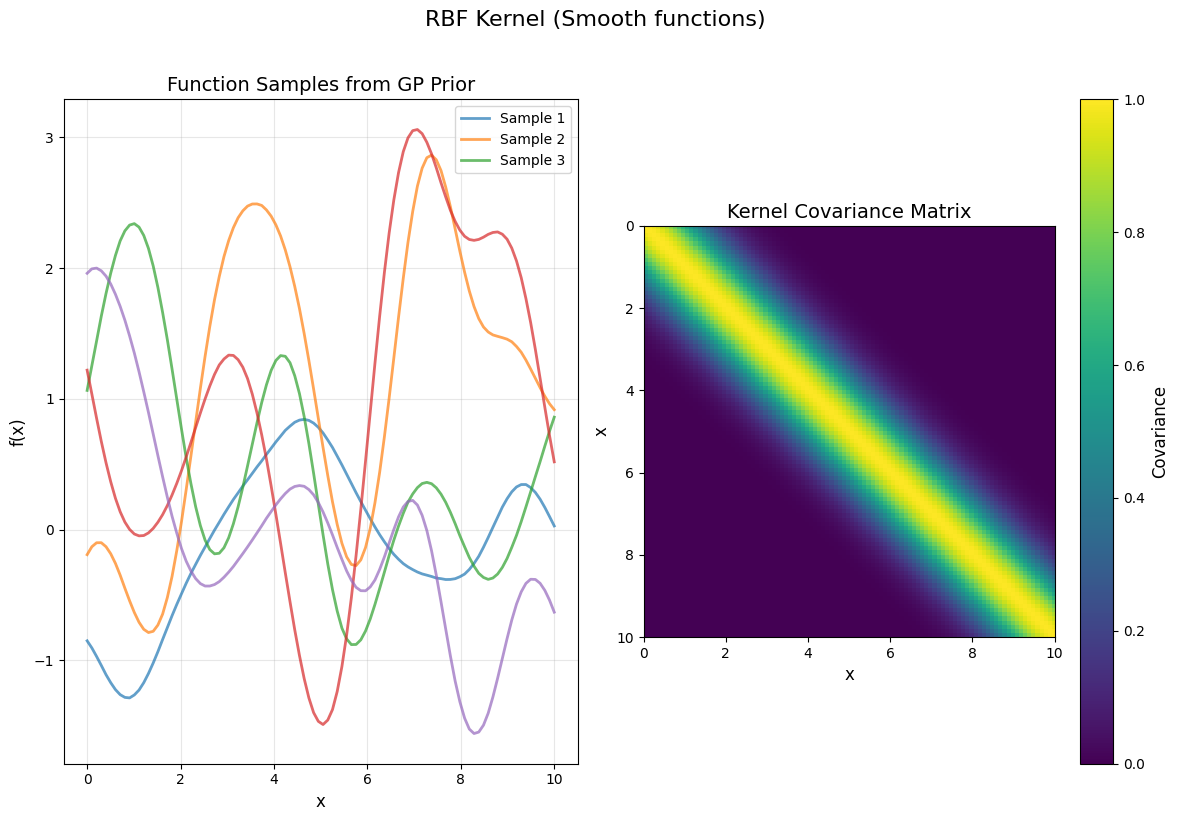

Kernel: RBF({'lengthscale': 1.0, 'variance': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: 1.02e+19

2. Linear Kernel:


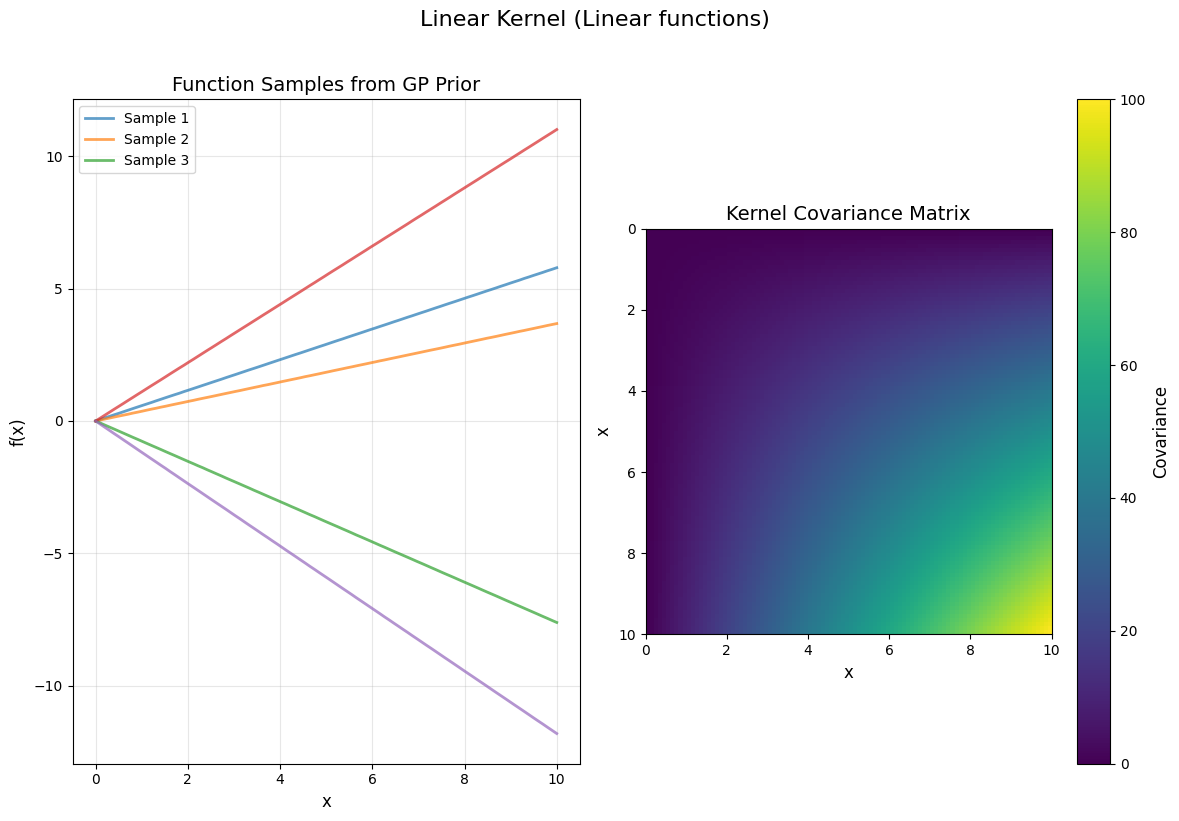

Kernel: Linear({'variances': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: inf

3. Periodic Kernel:


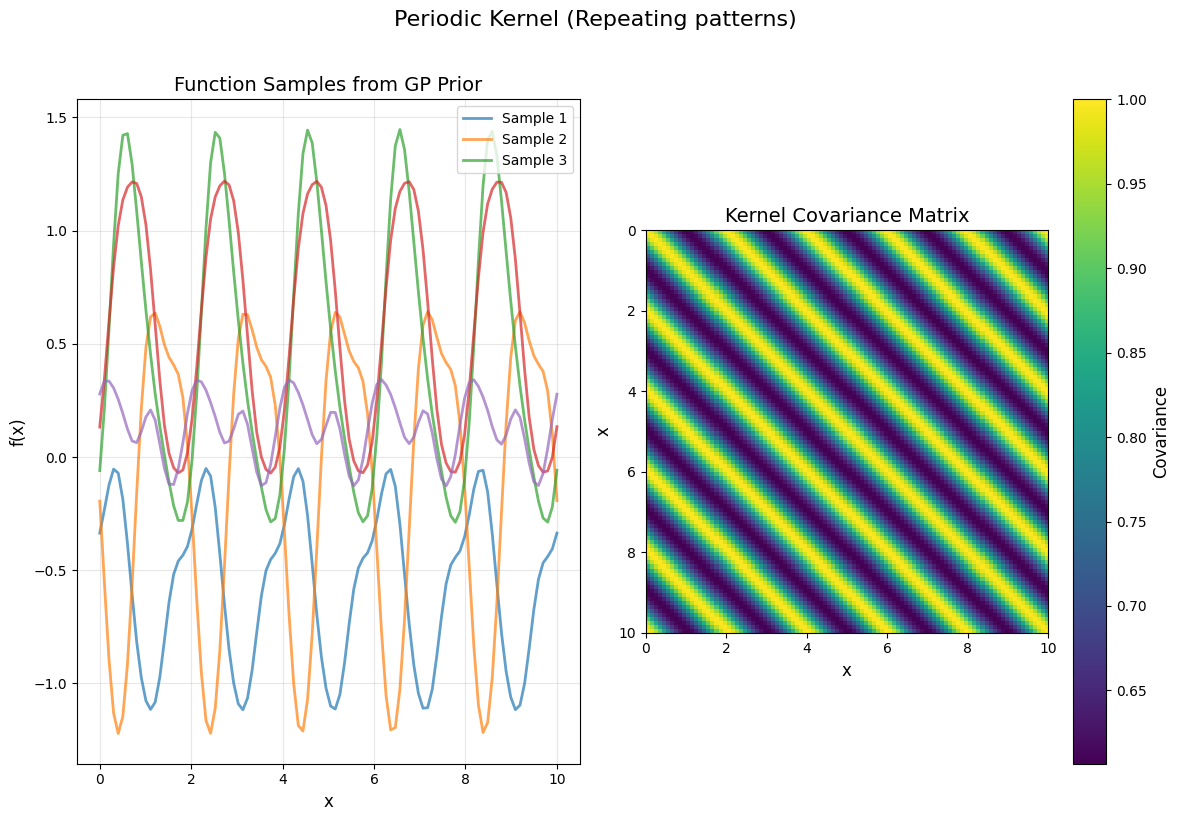

Kernel: Periodic({'period': 2.0, 'variance': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: 1.63e+19


In [9]:
# Demo: Visualize different kernel types
print("=== Visualizing Individual Kernels ===")

k = KernelFunction()

# 1. RBF kernel
print("\n1. RBF Kernel:")
k_rbf = k.rbf(lengthscale=1.0, variance=1.0)
plot_kernel_function(k_rbf, title="RBF Kernel (Smooth functions)")

# 2. Linear kernel  
print("\n2. Linear Kernel:")
k_linear = k.linear(variances=1.0)
plot_kernel_function(k_linear, title="Linear Kernel (Linear functions)")

# 3. Periodic kernel
print("\n3. Periodic Kernel:")
k_periodic = k.periodic(period=2.0, variance=1.0)
plot_kernel_function(k_periodic, title="Periodic Kernel (Repeating patterns)")

=== Visualizing Composite Kernels ===

Composite Kernel: ((RBF + Linear) * Linear)


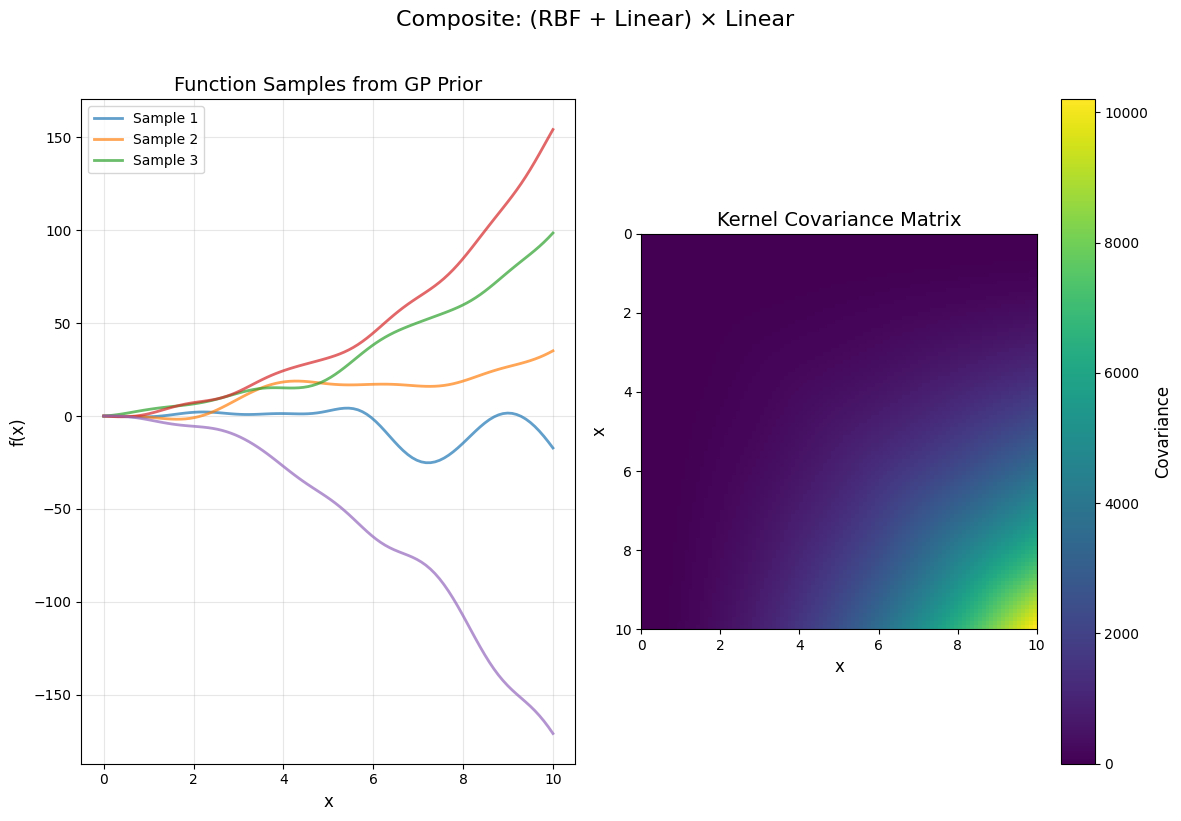

Kernel: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))
Kernel matrix shape: (100, 100)
Kernel matrix condition number: inf

=== Comparing Components vs Composite ===


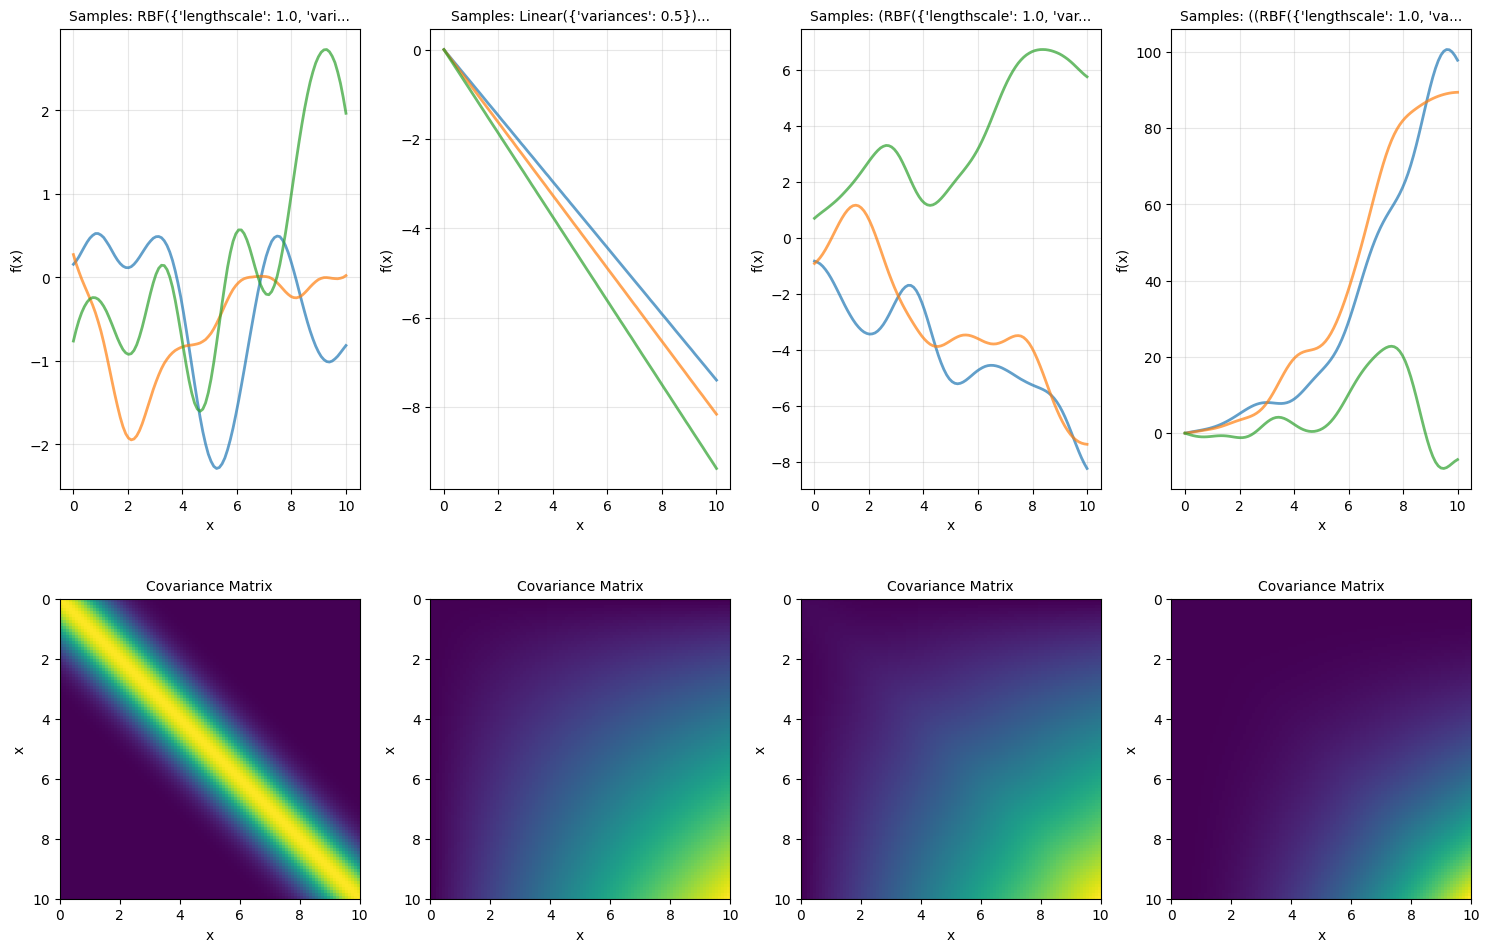

In [7]:
# Demo: Visualize composite kernels
print("=== Visualizing Composite Kernels ===")

k = KernelFunction()

# Create the example composite kernel from your notebook
k1 = k.rbf(lengthscale=1.0)
k2 = k.linear(variances=0.5)
k3 = k1.add(k2).multiply(k.linear(variances=2.0))

print("\nComposite Kernel: ((RBF + Linear) * Linear)")
plot_kernel_function(k3, title="Composite: (RBF + Linear) × Linear")

# Compare individual components vs composite
print("\n=== Comparing Components vs Composite ===")
compare_kernels(
    k1,  # RBF
    k2,  # Linear
    k1.add(k2),  # RBF + Linear
    k3   # (RBF + Linear) * Linear
)

=== Exploring Different Kernel Combinations ===
Comparing different kernel combinations:


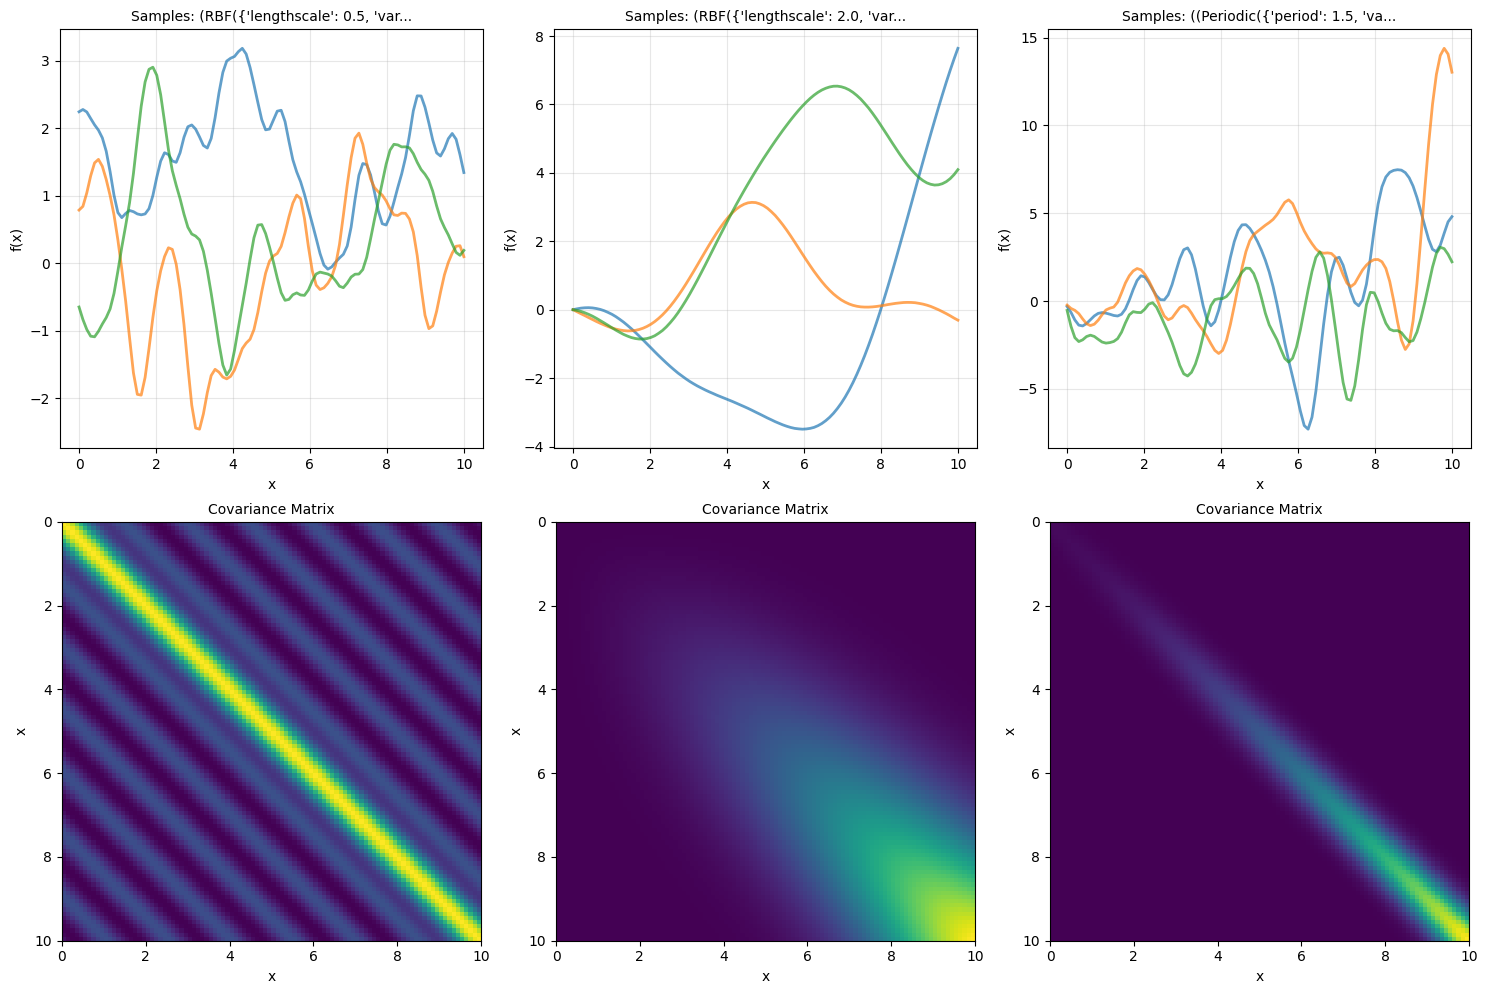

In [8]:
# Demo: Explore different combinations
print("=== Exploring Different Kernel Combinations ===")

k = KernelFunction()

# Different combinations to explore
rbf_short = k.rbf(lengthscale=0.5)  # Short lengthscale = more wiggly
rbf_long = k.rbf(lengthscale=2.0)   # Long lengthscale = smoother
periodic = k.periodic(period=1.5, variance=0.8)
linear = k.linear(variances=0.3)

# Create interesting combinations
combo1 = rbf_short.add(periodic)  # Smooth + Periodic
combo2 = rbf_long.multiply(linear)  # Smooth × Linear trend
combo3 = periodic.add(linear).multiply(rbf_short)  # Complex composite

print("Comparing different kernel combinations:")
compare_kernels(combo1, combo2, combo3)